In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import linalg
from scipy.optimize import root

import sys
sys.path.insert(0, 'code')

from robot_data import Load_Lidar_Scans as load_scans
from robot_data import Lidar_Scan
from robot_data import robot_trajectory
from datafilters import filters
import coordinate_transforms as cord_trans
import visualizer
import ICP

# All the variables that have been created to retrieve the data:

In [2]:
scans_OBJ = load_scans()
scans_OBJ.load_ranges('data\\LidarScans_ranges.txt')
scans_OBJ.load_angles('data\\LidarScans_angles.txt')

trajectory_OBJ = robot_trajectory()
trajectory_OBJ.load_trajectory('data\\Trajectory.txt')

print('Trajectory: ',trajectory_OBJ.trajectory.shape)
print('traj_len: ',trajectory_OBJ.trajectory_length)
print('traj_dim: ',trajectory_OBJ.trajectory_dimension,'\n')

print('LidarScans: ',scans_OBJ.LidarScan_ranges.shape)
print('num_of_lidarscans: ',scans_OBJ.num_of_LidarScans)
print('LidarScans_angles: ',scans_OBJ.LidarScan_angles.shape)

Trajectory:  (52, 3)
traj_len:  52
traj_dim:  2 

LidarScans:  (51, 240)
num_of_lidarscans:  240
LidarScans_angles:  (240,)


# The following variables are used for the pose-graph SLAM algorithm

In [4]:
neighbors_to_match_to = 3
# The number of points that read is matched to in the reference

match_threshold_distance = 1
# The maximum distance that a point in the read may be from a 
# point in the reference 

match_threshold_angle = np.pi/3
# The maximum angle between a line through a point in the 
# read may have from a line through a point in the reference

maximum_iterations = 80
# Maximum number of iterations that the ICP algorithm may be run

maximum_transform_limits = [0.8,15]
# maximum rotation and displacement limits between pose's

final_error_limit = 70
# maximum loop closure limit 

ICP_success = [0.001,0.01]
# conditions for success between successive ICP iterations

overlap_threshold = 0.75
# The amount of overlap that a read must have with the reference

robot_state = 0
# Indicates whether the robot is exploring or revisiting

keyframes = []
# Scans used to create the pose graph

local_map = []
# The sequence of keframes that the robot uses to create a map with 
# which it it comapres new scans to.

local_map_size = 3
# This is the number of keyframes that the robot uses to create the 
# local map, which it uses during exploration

no_loop_window = 10
# The number of previous and sequentail keyframes that may not be considered
# for the loop closure process

max_distance_to_loop_closing = 15
max_error_for_loop_closing = 5000

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [5]:
def linear_least_squares_SVD(reference_weighted,read,normals):#,transform):
    
    #x = np.transpose(transform)
    
    A = np.zeros([3])
    for point_read,norm in zip(read,normals):
        row = np.array([[point_read[1]*norm[0] - point_read[1]*norm[1],norm[0],norm[1]]])
        A = np.vstack((A,row))
    A = np.delete(A,0,0)
        
    b = np.zeros(1)
    for point_read,point_ref,norm in zip(read,reference_weighted,normals):
        row = np.array([norm[0]*point_ref[0] + norm[1]*point_ref[1] - norm[0]*point_read[0] - norm[1]*point_read[1]])
        b = np.hstack((b,row))
    b = np.delete(b,0,0)
    b = np.vstack(b)
    
    #U, s, Vh = linalg.svd(A, full_matrices=False)
    #S = np.diag(s)
    
    A_plus = linalg.pinv(A)
    
    return np.matmul(A_plus,b)

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [6]:
#transform = np.array([0,0.48,0])

read = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
reference = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

matched_coords, matched_distances, matched_point_indices = ICP.matching(reference, read,1)

normals_from_reference, principle_axes, distances_to_points = filters.surface_normals(reference,10)
distances_read_refnorm = matched_point_indices

read_to_ref_vectors_norm = filters.read_reference_normal_vectors(read,matched_coords)

angles_read_to_ref = ICP.observation_normal_angle_minimization(normals_from_reference,read_to_ref_vectors_norm)

rejection_weights = ICP.outlier_rejection(matched_distances,angles_read_to_ref)
#############################
temp2 = np.array([9,9])
for all_points in matched_coords:
    for single_match in all_points:
        temp = single_match
    temp2 = np.vstack((temp2,temp))
temp2 = np.delete(temp2,0,0)
#############################
weighted_matched_coords = np.matmul(rejection_weights,temp2)

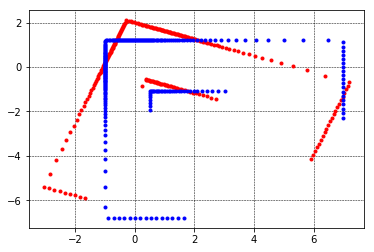

In [7]:
#theta,tx,ty = [0, 0.48333001, 0.0]
theta,tx,ty = [0, 0.48333001, 0]
new_read = ICP.transformation_2D([theta,tx,ty],read)

for i in range(100):
    old_theta,old_tx,old_ty = theta,tx,ty
    theta,tx,ty = linear_least_squares_SVD(weighted_matched_coords,new_read,normals_from_reference)
    theta,tx,ty = theta[0],tx[0],ty[0]
    new_read = ICP.transformation_2D([theta,tx,ty],read)
    #if(((np.abs(old_theta - np.abs(theta)) <= old_theta*0.1) and (np.abs(old_tx - np.abs(tx)) <= old_tx*0.1) and (np.abs(old_ty - np.abs(ty)) <= old_ty*0.1) or i >= maximum_iterations)):
        

plt.figure()
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.plot(new_read[:,0],new_read[:,1],'r.')
plt.plot(reference[:,0],reference[:,1],'b.')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Goal of ICP

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
#translation = np.vstack((0,trajectory_OBJ.trajectory[1] - trajectory_OBJ.trajectory[0]))
transformation = np.array([[0],[0.48333],[0]])
test = ICP.transformation_2D(transformation,coords_xy)

plt.figure()
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.plot(trajectory_OBJ.trajectory[0,0] + test[:,0],trajectory_OBJ.trajectory[0,0] + test[:,1],'.')

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,0] + coords_xy[:,1],'.')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Creating the inital guess for the transform

In [8]:
def transformation_parameters(path):
    parameters = []
    x0 = path[0]
    path = np.delete(path,0,0)
    prev_pose = x0
    for curr_pose in path:
        translation = curr_pose[0:2:1] - prev_pose[0:2:1]
        if not (curr_pose[2] == prev_pose[2]):
            theta = curr_pose[2]
        else:
            theta = 0
        parameters.append([theta,translation[0],translation[1]])
        prev_pose = curr_pose
    return parameters

In [9]:
transformations_entire_path = transformation_parameters(trajectory_OBJ.trajectory)
print(transformations_entire_path[0])

[0, 0.48333001, 0.0]


plt.figure()
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')

for i,transform in enumerate(transformations_entire_path):
    theta,tx,ty = transform
    #T = np.array([[1,0,tx],[0,1,ty],[0,0,1]])
    #print(T,'\n')
    #row0 = np.hstack((np.cos(theta),np.sin(theta),0))
    #row1 = np.hstack((-1*np.sin(theta),np.cos(theta),0))
    #row2 = np.hstack((0,0,1))
    #R = np.vstack((row0,row1,row2))
    #print(R,'\n')
    #rigid_transformation = np.matmul(T,R)
    #print(rigid_transformation)
    
    coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[i])
    
    test = ICP.transformation_2D([[theta],[tx],[ty]],coords_xy)

    plt.plot(test[:,0],test[:,1],'.')

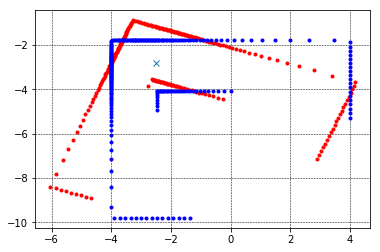

In [10]:
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
translation = np.vstack(trajectory_OBJ.trajectory[1] - trajectory_OBJ.trajectory[0])

test = ICP.transformation_2D([theta,tx,ty],coords_xy)

plt.figure()
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.plot(trajectory_OBJ.trajectory[0,0] + test[:,0],trajectory_OBJ.trajectory[0,0] + test[:,1],'r.')

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,0] + coords_xy[:,1],'b.')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# Testing

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

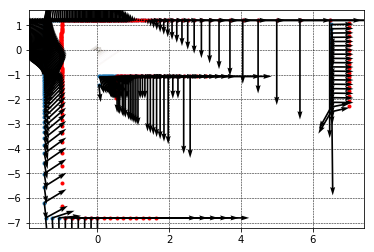

In [11]:
coords_xy1 = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
coords_xy0 = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

normals_read_to_ref = filters.read_reference_normal_vectors(coords_xy1,coords_xy0)

start,end,interval = 0,240,240
steps = np.linspace(start,end,interval,endpoint=False,dtype='int')

plt.figure()

plt.plot(coords_xy1[steps,0],coords_xy1[steps,1],'.')
plt.grid(color='k', linestyle='--', linewidth=0.5)

for i in steps:
    visualizer.plot_custom_axes(normals_read_to_ref[i],coords_xy1[i])
    
plt.plot(coords_xy0[steps,0],coords_xy0[steps,1],'r.')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

ICP matching process with adjustable number of matches

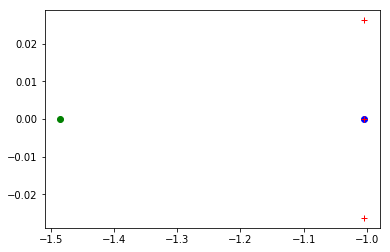

In [12]:
reference = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
read = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])

matched, ditances, correspondence_points = ICP.matching(reference, read,3)

plt.figure()
plt.plot(reference[0,0],reference[0,1],'bo')
plt.plot(read[0,0],read[0,1],'go')
for all_points in matched:
    for point in all_points:
        plt.plot(point[0],point[1],'r+')
    break

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Angle minimization between the unit vector from read to reference and the notmal vector at the reference

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

normal_vectors,axes, distances = filters.surface_normals(coords_xy,10)
observation_directions = filters.sensor_to_observation_vectors_cartesian(coords_xy)

angles = np.rad2deg(ICP.observation_normal_angle_minimization(normal_vectors,observation_directions))

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [13]:
def transformation_2D_homogeneous(parameters,x):
    
    theta,tx,ty = parameters
    cosine = np.cos(theta)
    sine = np.sin(theta)
    
    rotation_matrix_mini = np.array([[cosine,sine],[-1*sine,cosine]])
    translation_matrix = np.vstack([tx,ty])
    
    motion_matrix = np.vstack((np.hstack((rotation_matrix_mini,translation_matrix)),[0,0,1]))
    
    new_cloud = np.matmul(motion_matrix,x)
    
    return new_cloud

In [23]:
def plot_custom_axes(axis,origin_coords):
    for x_axis, y_axis in axis:
        print(x_axis, y_axis)
        plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=0.01)
        plt.quiver(origin_coords[0], origin_coords[1], x_axis, y_axis, zorder=11, width=0.005, scale=15)
        plt.grid(color='k', linestyle='--', linewidth=0.5)

    return

[[1]
 [0]]
[[2.00000]
 [-1.00000]]


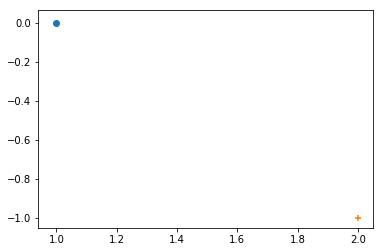

In [36]:
vector = np.vstack([1,0,1])
new_vector = transformation_2D_homogeneous([0,1,-1],vector)
print(vector[:2])
print(new_vector[:2])
plt.scatter(vector[0],vector[1],marker='o')
plt.scatter(new_vector[0],new_vector[1],marker='+')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Data filters, fized sample step size

In [ ]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = filters.subsample(coords_xy,6)
plt.plot(test[:,0],test[:,1],'.')

data filters, randomly sampled points with probability of retained points

In [ ]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = filters.random_sample_uniform(coords_xy,0.5)
plt.plot(test[:,0],test[:,1],'.')

print(test.shape[0]/coords_xy.shape[0])

Data filters, fixed bounded box filter rejecting every thing outs side the box

In [ ]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

test = filters.bounded_box(test,[-2,2],[-2,2])
plt.plot(test[:,0],test[:,1],'.')

Data filters,orientate the normal vectors to a point 

In [ ]:
start,end,interval = 0,240,240
neighbors = 10
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
steps = np.linspace(start,end,interval,endpoint=False,dtype='int')

#plt.figure()

#plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
#plt.plot(0,0,'x')
#plt.grid(color='k', linestyle='--', linewidth=0.5)

normal_vectors,axes, distances = filters.surface_normals(coords_xy,neighbors)
observation_directions = filters.sensor_to_observation_vectors_cartesian(coords_xy)

#for i in steps:
#    observation_direction_for_point = observation_directions[i]
#    visualizer.plot_custom_axes(observation_direction_for_point,coords_xy[i])

plt.figure()

plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

for i in steps:
    visualizer.plot_custom_axes(normal_vectors[i],coords_xy[i])
    
plt.figure()

#plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
#plt.plot(0,0,'x')
#plt.grid(color='k', linestyle='--', linewidth=0.5)    

#for i in steps:
#    axis_for_point = axes[i]
#    visualizer.plot_custom_axes(axis_for_point,coords_xy[i])
    
normal_vectors = filters.orientate_normals(normal_vectors,observation_directions)

plt.plot(coords_xy[steps,0],coords_xy[steps,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

for i in steps:
    visualizer.plot_custom_axes(normal_vectors[i],coords_xy[i])

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Testing the co-ordinate transforms

In [ ]:
plt.figure()

plt.subplot(1, 2, 1)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2,projection='polar')
coords_polar = cord_trans.cartesian_to_ploar_2D(coords_xy)
plt.polar(coords_polar[:,0],coords_polar[:,1],'.')
plt.polar(0.,0.,'x')

In [ ]:
plt.figure()

plt.subplot(1, 2, 1)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[10])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

In [ ]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,1] + coords_xy[:,1],'.')
plt.plot(trajectory_OBJ.trajectory[0,0],trajectory_OBJ.trajectory[0,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[10])
plt.plot(trajectory_OBJ.trajectory[10,0] + coords_xy[:,0],trajectory_OBJ.trajectory[10,1] + coords_xy[:,1],'.')

In [ ]:
visualizer.plot_scan_surfaces(cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0]),cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])[0:21])

In [ ]:
axes = np.array([[1.,0.],[0.,-1.]])
print(axes.shape)
visualizer.plot_custom_axes(axes,[0.01,-0.01])
axes = np.array([[-1.,0.],[0.,1.]])
print(axes.shape)
visualizer.plot_custom_axes(axes,[-0.01,0.01])

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [10]:
A = np.matrix([[2, -1, 0],[4,3,-2]])
u, s, vt = np.linalg.svd(A, full_matrices=True)
vt = np.transpose(vt)
ss = np.diag(s)
anp = vt * ss * np.transpose(u)
hand = np.invert(np.transpose(A)*A)*np.transpose(A)
apos = np.linalg.pinv(a)

ValueError: shapes (3,3) and (2,2) not aligned: 3 (dim 1) != 2 (dim 0)

In [7]:
print(hand)
print(apos)
print(anp)

[[ -31 -131]
 [ -11  -87]
 [   9   53]]
[[ 0.31666667  0.08333333]
 [-0.36666667  0.16666667]
 [ 0.08333333 -0.08333333]]
